In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import tidynamics as tid
import os

from copy import deepcopy
from time import time
from numba import njit

In [2]:
class Polymer:
    
    def __init__(self,
                 n_beeds:           int     = 10,
                 r_beed:            float   = 1.0,
                 q_beed:            float   = 2.08,
                 bonds:             list    = None,
                 mobility:          float   = 0.002,
                 force_constant_nn: float   = 100.0,
                 epsilon_LJ:        float   = 0.25,
                 sigma_LJ:          float   = 2.0,
                 lB_debye:          float   = 3.077,
                 c_S:               float   = 10,
                 cutoff_debye:      float   = 4.0,
                 pbc:               bool    = True,
                 box_length:        float   = None,
                 cwd:               str     = "/home/jan/Documents/masterthesis/project/mucus"):
    
        self.n_beeds            = n_beeds
        self.r_beed             = r_beed
        self.q_beed             = q_beed
        self.mobility           = mobility
        self.force_constant_nn  = force_constant_nn
        self.epsilon_LJ         = epsilon_LJ
        self.sigma_LJ           = sigma_LJ
        self.lB_debye           = lB_debye # units of beed radii
        self.c_S                = c_S # salt concentration [c_S] = mM
        self.cutoff_debye       = cutoff_debye
        self.cutoff_pbc         = cutoff_debye # NOTE here the debye cutoff is used since it is the force with the longest range
        self.pbc                = pbc
        self.bonds              = bonds
        self.cwd                = cwd       
        
        self.r0_beeds           = 2*r_beed
        self.A_debye            = self.q_beed**2*self.lB_debye
        self.B_debye            = 1/(r_beed*38.46153*self.c_S) # 1/(debye screening length) in units of beed radius
    
    # TODO is there a better way to do this??
        if box_length is None:
            self.box_length_half = 2*r_beed*n_beeds  # make box length 2 times chain length (arbitrary)
        else:
            self.box_length_half = box_length    
            
        
    # TODO: make all variables "None" and initialize in methods
        
        self.positions              = None
        self.positions_new          = np.zeros((n_beeds, 3))
        self.velocities             = np.zeros((n_beeds, 3))
        self.forces                 = np.zeros((n_beeds, 3))
        self.energy                 = 0
        self.trajectory             = np.zeros((1, n_beeds, 3)) # first dim is the frame
        self.distances_bonded       = list(())
        self.directions_bonded      = list(())
        self.distances              = list(())
        self.directions             = list(())
        self.cm_trajectory          = None
        self.msd                    = None
        self.structure_factor       = None
    
    # TODO: redo the get_bonds() method so that every bond pair only exists once
    
    def create_chain(self, 
                     axis: int = 0):
        """
        Create linear chain along specified axis, centered in the origin.
        The get_bonds() method is called here automatically.
        
        Arguments:
            axis (int): specify on which axis the chain lies on (0,1,2) -> (x,y,z)
        """
        
        self.positions = np.zeros((self.n_beeds, 3))
        
        for k in range(self.n_beeds):
            self.positions[k, axis] = k*self.r0_beeds
        
        #center chain around 0
        if self.n_beeds != 1:
            self.positions[:, axis] -= self.r0_beeds*(self.n_beeds-1)/2

        # set first trajecory frame to initial position
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        self.get_bonds()
        
        return
    
    def create_test_chain(self, 
                          sigma: float = 0.05, 
                          axis: int = 0):
        """
        Create linear chain along specified axis, centered in the origin.
        The positions of the linear chain are deviated wit a gaussian noise 
        of standard deviation sigma.
        The get_bonds() method is called here automatically.
        
        Arguments:
            sigma (float): standard deviation for the displacement
            axis (int): specify on which axis the chain lies on (0,1,2) -> (x,y,z)
        """
        
        for k in range(self.n_beeds):
            self.positions[k, axis] = k*self.r0_beeds
        
        #center chain around 0
        if self.n_beeds != 1:
            self.positions[:, axis] -= self.r0_beeds*(self.n_beeds-1)/2
        
        # to test forces
        self.positions += np.random.randn(self.n_beeds, 3)*sigma

        # set first trajecory frame to initial position
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        self.get_bonds()
        
        return
    
    def get_bonds(self):
        """
        Create list of bond pair indices. 
        Bonds are saved twice, i.e.: (..., (i, j), ... , (j, i), ...)
        """
        #define bonds
        if self.bonds is None: 
            # if bonds are not already defined, create chain
            self.bonds =list(())
            self.bonds.append((0,1))
            for k in range(1, self.n_beeds-1):
                self.bonds.append((k, k-1))
                self.bonds.append((k, k+1))
            self.bonds.append((self.n_beeds-1, self.n_beeds-2))
            
            self.bonds = np.array(self.bonds)
        
        # calculate distances and directions for every bond tuple
        self.get_distances_directions()
        
        return
    
    def get_distances_directions(self):
        """
        Get distances and directions for every bond, saved in the self.bond list
        The directions are not normalized, since the normalization happens in the forcefiled calculation.
        """
        # TODO: CHANGE THIS SO ALL DISTANCES ARE CALCULATED ONCE AND BONDED ONES ARE INDEXED BY BONDS
        # meaning that the distances dont have to be calculated for every force
        # i.e. also include distances for nonbonded atoms 
        
        self.distances_bonded = list(()) # reset
        self.directions_bonded = list(()) 
        # TODO: remove double calculation
        for bond in self.bonds:
            
            r_vec = self.positions[bond[1]] - self.positions[bond[0]]
            r = np.sqrt(np.dot(r_vec, r_vec))
            #r = np.linalg.norm(r_vec)
            
            self.distances_bonded.append(r)
            self.directions_bonded.append(r_vec/r)
        
        self.distances_bonded = np.array(self.distances_bonded)
        self.directions_bonded = np.array(self.directions_bonded)
        
        # fix directions and distances for pbc
        # if self.pbc == True:
            
        return

    def get_forces(self):
        """
        Delete all old forces and add all forces occuring in resulting from the self.positions configuration
        """
        
        #delete old forces
        self.forces = np.zeros((self.n_beeds, 3))
        
        self.force_NearestNeighbours()
        self.force_LennardJones_cutoff()
        self.force_Debye()
        
        return

    def get_forces_test(self):
        """
        for testing the forces
        """
        print("Position")
        print(self.positions)
        
        #delete old forces
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_NearestNeighbours()
        print("nearest neighbours")
        print(self.forces)
        
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_LennardJones()
        print("Lennard Jones")
        print(self.forces)
        
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_Debye()
        print("Debye")
        print(self.forces)
        
        return
    
    # TODO: reduce every unnecessary calculation in the forces
    
    def force_NearestNeighbours(self):
        """
        harmonice nearest neighhbour interactions
        """
        
        # calculate the force of every bond at once
        f_temp = 2*self.force_constant_nn*(self.distances_bonded-self.r0_beeds)
        
        for k, beed_idx in enumerate(self.bonds[:, 0]):
            #print(k, beed_idx)
            self.forces[beed_idx, :] += f_temp[k]*self.directions_bonded[k]
        
        return
    
    def force_LennardJones(self):
        """
        LJ nearest neighhbour interactions
        """
        f_temp = 4*self.epsilon_LJ*(-12*self.sigma_LJ**12/self.distances_bonded**13 + 6*self.sigma_LJ**7/self.distances_bonded**7)
        
        for k, beed_idx in enumerate(self.bonds[:, 0]):
            #print(k, beed_idx)
            self.forces[beed_idx, :] += f_temp[k]*self.directions_bonded[k]
        
        return
    
    def force_LennardJones_cutoff(self):
        """
        LJ interactions using a cutoff
        """
        
        cutoff = 2*self.r_beed

        for i in range(self.n_beeds-1):
            for j in range(i+1, self.n_beeds):
                r_vec = self.positions[j] - self.positions[i]
                r = np.sqrt(np.dot(r_vec, r_vec))
                
                if r < cutoff:
                    f_temp = 4*self.epsilon_LJ*(-12*self.sigma_LJ**12/r**14 + 6*self.sigma_LJ**7/r**8)
                    self.forces[i, :] += f_temp*r_vec
                    self.forces[j, :] -= f_temp*r_vec
            
        return
    
    def force_Debye(self):
        """
        non bonded interaction (debye screening)
        """
        
        for i in range(self.n_beeds-1):
            for j in range(i+1, self.n_beeds):
                r_vec = self.positions[j] - self.positions[i]
                r = np.sqrt(np.dot(r_vec, r_vec))
                
                if r < self.cutoff_debye:
                    # the 1/r**2 factor comes from the normalisation of the direction vector
                    f_temp = -self.A_debye*(1+self.B_debye*r)*np.exp(-self.B_debye*r)/r**3
                    self.forces[i, :] += f_temp*r_vec
                    self.forces[j, :] -= f_temp*r_vec
        
        return 

    
    def force_Random(self):
        """
        Gaussian random Force with a per particle standard deviation of sqrt(6 mu_0) w.r.t. its absolute value
        """
        
        # since the std of the foce should be sqrt(6*mu) but the std of the absolute randn vector is sqrt(3)
        # the std used here is sqrt(2*mu)
        
        return np.sqrt(2*self.mobility)*np.random.randn(self.n_beeds, 3)
    
    
    def analytical_potential_function(self, 
                                      r = None):
        """
        Calculates the analytical interatomic potential of two bonded beeds, using 
        the parameters specified in __init__.
        This function is used for plotting.
        
        Parameters:
            r (ndarray):
                vector of distances between two beeds
        
        Returns:
            r (ndarray):
                vector of distances between two beeds
            U (ndarray):
                theoretical potential U(r)
        """
        
        if r is None:
            r = np.linspace(self.r0_beeds-self.r_beed,self.r0_beeds+self.r_beed, 100)
        
        L_s = 1/(38.46153*self.c_S)
        
        u_nn = self.force_constant_nn*(r-self.r0_beeds)**2
        u_LJ = 4*self.epsilon_LJ*(self.sigma_LJ**12/r**12 - self.sigma_LJ**7/r**6 + 1)
        u_Deb = self.A_debye*np.exp(-self.B_debye*r)/r
        
        # apply cutoff
        u_LJ[r>2*self.r_beed] = 0
        u_Deb[r>self.cutoff_debye] = 0
   
        return r, u_nn + u_LJ + u_Deb
    
    def get_CM_trajectory(self):
        """
        Calculates the center of mass for every frame in the trajectory, assuming equal mass for every 
        beed and saves it into a trajecorty. 
        """
        
        traj_cm = list(())

        #calculate trajectory for center of mass
        for frame in self.trajectory:
            traj_cm.append(np.sum(frame, axis=0))
            
        self.cm_trajectory = np.array(traj_cm)/self.n_beeds
            
        return 
    
    def get_CM_MSD(self, 
                   plot: bool = False):
        """
        Calculates the mead squared deviation of the center of mass to its original position.
        If plot is True, a log-log plot of the absolute MSD and the MSD for every CM coordinate is calculated
        and compared to the theoretical curve resulting from the mu_0 input.
        
        Parameters:
            plot (bool):
                wether to print the plot
        """
        
        # check if cm_traj has already been calculated
        if self.cm_trajectory is None:
            self.get_CM_trajectory()
            traj_cm = self.cm_trajectory
        else:
            traj_cm = self.cm_trajectory
        
        # TODO: saving cm trajectory into new array is unnecessary, clean all unnecessary variables
        
        msd_tid = tid.msd(traj_cm)
        self.msd = msd_tid
        
        if plot is True:
            msd_tid_x = tid.msd(traj_cm[:,0])
            msd_tid_y = tid.msd(traj_cm[:,1])
            msd_tid_z = tid.msd(traj_cm[:,2])
            
            n_frames = len(traj_cm)
            t = np.arange(n_frames)
        
            plt.figure()
            plt.loglog(t[1:], 2*t[1:]*self.mobility, label=r"$2t\tilde{\mu}_0$", linestyle="--")
            plt.loglog(t[1:], 6*t[1:]*self.mobility, label=r"$6t\tilde{\mu}_0$", linestyle="--")
            plt.loglog(t[1:], msd_tid[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}^2\rangle$")
            plt.loglog(t[1:], msd_tid_x[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_x^2\rangle$")
            plt.loglog(t[1:], msd_tid_y[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_y^2\rangle$")
            plt.loglog(t[1:], msd_tid_z[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_z^2\rangle$")
            plt.xlabel(r"$t/\Delta t$")
            plt.ylabel("MSD (center of mass)")
            plt.legend()
            plt.show()
            
        return
    
    
    def plot_distance_distribution(self, 
                                   n_bins: int = 100, 
                                   bin_interval: tuple = None):
        """
        Plots a normalized distribution of all bonded distances in the trajectory
        and compares it to the Bolzmann distribution.
        
        Parameters:
            n_bins (int):
                number of bins in the histogram
            bin interval (tuple):
                left and right bin boundaries
        """
    
        distances_nn = list(())
        # for every frame calculate the distance between neighbouring atoms is the chain
        for frame in self.trajectory:
            distances_nn.append(np.sqrt(np.sum((frame[:self.n_beeds-1] - frame[1:])**2, axis=1)))

        distances_nn = np.array(distances_nn).ravel()
        
        if bin_interval is None:
            bin_interval = (np.min(distances_nn), np.max(distances_nn))

        # create normalized histogram
        histogram_nn, edges_nn = np.histogram(distances_nn, bins=n_bins, range=bin_interval, density=True)
        
        r, E_pot = self.analytical_potential_function(edges_nn[:n_bins])
        E_pot_normalize = np.sum((edges_nn[1:]-edges_nn[:n_bins])*np.exp(-E_pot) * 4*np.pi*edges_nn[:n_bins]**2) # here the jacobi determinant for spherical coordinates is added

        plt.figure()
        plt.plot(r - (r[1]-r[0]), histogram_nn, label=r"$p(\Delta\tilde{r})$")
        plt.plot(r, 4*np.pi*r**2*np.exp(-E_pot)/E_pot_normalize, label=r"$\frac{1}{Z}\mathrm{exp}\{-\tilde{U}(\tilde{\Delta r})\}$")
        plt.legend()
        plt.xlabel(r"$\Delta\tilde{r}$")
        plt.ylabel(r"$p(\tilde{r})$")
        plt.grid()
        plt.show()
        
        return
    
    def get_structure_factor(self,
                        q = None):
        """
        Calculates the structure factor of an isotropic system for different wavenumbers q
        Averaged over the whole trajectory
        
        Parametetrs
            q (ndarray):
                1D array of wavenumbers
        """ 
        if q is None:
            q = np.linspace(0.01, 0.8, 300) # kinda arbitrary right now
            # q_vec = q_i - q_s (i=incident, s=scattered), |q_i|=|q_s|=2pi n/lambda
            # q = 4 pi n/lamda * sin(theta/2)
            # n... refractive index of the solution
            # lambda... wavelength of the beam
            # theta... angle between incident beam and scattered beam
            
        # NOTE q could also be calculated using a scattering angle and a wavelength vector:
        # lam = np.linspace(0.5, 20, 300) # wavelength in reduced units
        # n = 1.1 # refractive index
        # theta = 0.05 #scattering angle
        # q = 4*np.pi*n/lam * np.sin(theta/2)
        
        # NOTE for small angle scattering one could use approximations for better performance
            
        q = np.array(q)
        
        self.structure_factor = np.zeros(len(q))
               
        for frame in self.trajectory:
            for i in range(self.n_beeds-1):
                for j in range(i+1, self.n_beeds):
                    r = frame[j] - frame[i] 
                    qr = q*np.sqrt(np.dot(r, r))
                    self.structure_factor += np.sin(qr)/qr
        
        #factor 2 because of double sum reduction from i,j to i<j
        self.structure_factor = self.structure_factor*2/self.n_beeds**2/len(self.trajectory)
        
        return
    
    def create_topology_pdb(self):
        """
        Creates a pdb topology of the current system
        """
        
        
        file_name = f"polymer_{self.n_beeds:d}_beeds"

        # create pdb file
        pdb_file = "topologies/"+file_name+".pdb"


        with open(pdb_file, "w") as f:
            f.write("HEADER\t"+file_name+"\n")
            f.write(f"CRYST1   60.000   60.000   60.000  90.00  90.00  90.00 P 1           1 \n")
            
            # create chain along the x-axis
            for k in range(self.n_beeds):
                #f.write(f"HETATM{k+1:5d}	 CA	 HET X       {k*chain_beed_distance+chain_beed_distance:6.3f}   0       0  1.00  0.00          Ca  \n")
                f.write(f"HETATM{k+1:5d} CA   HET X{k+1:4d}    {k*self.r0_beeds+self.r0_beeds:8.3f}{0.0:8.3f}{0.0:8.3f}{1.0:6.2f}{0.0:6.2f}           C  \n")
            #terminate chain
            f.write(f"TER    {k+2:4d}      HET X {k+1:3d}\n")
            
            # add bonds
            f.write(f"CONECT{1:5d}{2:5d}\n") #first beed
            for k in range(2, self.n_beeds):
                f.write(f"CONECT{k:5d}{k-1:5d}{k+1:5d}\n") #middle beeds
            f.write(f"CONECT{self.n_beeds:5d}{self.n_beeds-1:5d}\n") #last beed
            
            f.write("END\n")
            f.close()
        
        return

    def save_traj_gro(self, fname_traj=None):
        """
        Saves trajectory in a gromacs trajectory, using mdtraj
        """
        
        fname_top = os.path.join(self.cwd, f'topologies/polymer_{self.n_beeds:d}_beeds.pdb')

        if os.path.exists(fname_top) == False:
            self.create_topology_pdb()
        
        if fname_traj is None:
            fname_traj = os.path.join(self.cwd, f"trajectories/traj_{self.n_beeds:d}beeds_{len(self.trajectory):d}frames_{self.mobility:.5f}mu.gro")
        
        # save trajectory in mdtraj to create .gro simulation trajectory
        topology = md.load(fname_top).topology
        trajectory = md.Trajectory(self.trajectory, topology)

        # save as gromacs file
        trajectory.save_gro(filename=fname_traj)
        
        return
    
    def load_traj_gro(self, 
                      fname: str = None,
                      overwrite: bool = False):
         
        if fname is None:
            raise TypeError("Error: provide filename")
        if os.path.exists(fname) != True:
            raise TypeError(f"Error: file \"{fname:s}\" does not exist")
        
        if overwrite == False:
            # TODO remove the "or" once the initialisation is fixed
            if (self.trajectory is None) or (len(self.trajectory<2)):
                raise Exception("Error: Polymer object already has a trajectory")
            else:
                self.trajectory = md.load(fname).xyz
        else:
            self.trajectory = md.load(fname).xyz
        
        
        self.positions = self.trajectory[-1]
        self.get_bonds()
    
    def apply_pbc(self):
        
        # shift box to positive quadrant
        self.positions += self.box_length_half
        
        # calculate modulo L
        self.positions = np.mod(self.positions, 2*self.box_length_half)
        
        # shift back
        self.positions -= self.box_length_half
        
        return
        
    def simulate(self, 
                 steps: int = 10000, 
                 write_traj: bool = True, 
                 stride: int = 1):
        """
        Simulates the brownian motion of the system with the defined forcefield using forward Euler.
        """
        
        if self.positions is None:
            self.create_chain()
        
        if self.bonds is None:
            self.get_bonds()
        
        for step in range(steps-1):
            
            # get distances for interactions
            self.get_distances_directions()
            
            # get forces
            #self.get_forces_test()
            self.get_forces()
            
            # integrate
            # NOTE: the timestep of the integrator is already implicitly contained in the particle mobility
            self.positions = self.positions + self.mobility*self.forces + self.force_Random()
            
            # apply periodic boundary conditions
            self.apply_pbc()
            
            # This would be needed if the velovity is calculated:
            #self.positions_new = self.positions + self.mobility*self.forces + self.force_Random()
            #self.velocities = (self.positions - self.positions_new)
            #self.positions = deepcopy(self.positions_new)
            
            # write trajectory for every stride frames
            if (write_traj==True) and (step%stride==0):
                self.trajectory = np.append(self.trajectory, [self.positions], axis=0)
            
            if np.any(self.distances_bonded > 5):
                print("System exploded")
                print("simulation Step", step)
                #print(self.forces)
                #print(self.distances_bonded)
                break

        return

IndentationError: expected an indented block after 'if' statement on line 168 (2431566418.py, line 171)

simulation time
1:21 min


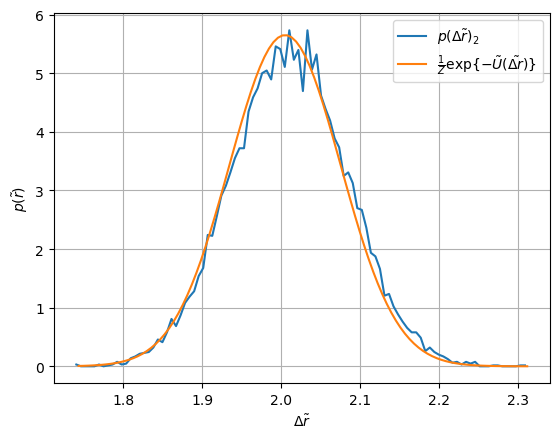

In [34]:
#single simulation
mobility = 0.00005
steps = 30000

#parameter = (0.25, 2.08, 10)
parameter = (0, 0, 20)

eps = parameter[0]
q = parameter[1]
n_beeds = parameter[2]

p1 = Polymer(n_beeds=n_beeds, mobility=mobility, epsilon_LJ=eps, q_beed=q)
# p1 = Polymer(n_beeds=n_beeds, mobility=mobility)
p1.create_chain(axis=1)

t1 = time()
p1.simulate(steps, stride=50)
t2 = time()

print("simulation time")
print(f"{(t2-t1)//60:.0f}:{(t2-t1)%60:2.0f} min")

#1.save_traj_gro()    

#p1.get_CM_MSD(plot=True)
p1.plot_distance_distribution()


In [13]:
print(os.path.exists("./trajectories/traj_50beads_500000steps_0.000050mu_50stride.gro"))

True


In [28]:
# load traj into Polymer
#single simulation
mobility = 0.00005
steps = 30000
n_beeds = 50

fname = "./trajectories/traj_50beads_500000steps_0.000050mu_50stride.gro"

p = Polymer(n_beeds=n_beeds, mobility=mobility)
p.load_traj_gro(fname=fname, overwrite=True)
#p.plot_distance_distribution()



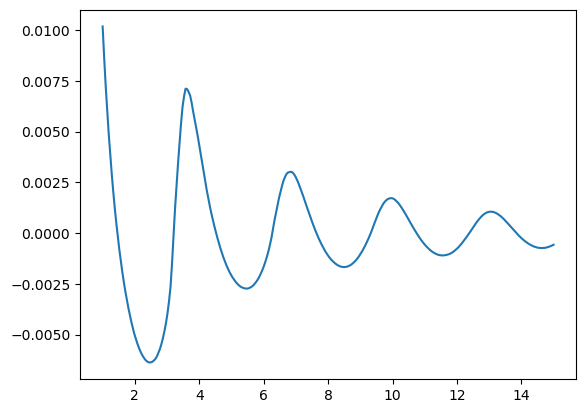

In [29]:
q = np.linspace(1, 15, 300)

p.get_structure_factor(q=q)

plt.figure()
plt.plot(q, p.structure_factor)
#plt.loglog()
plt.show()

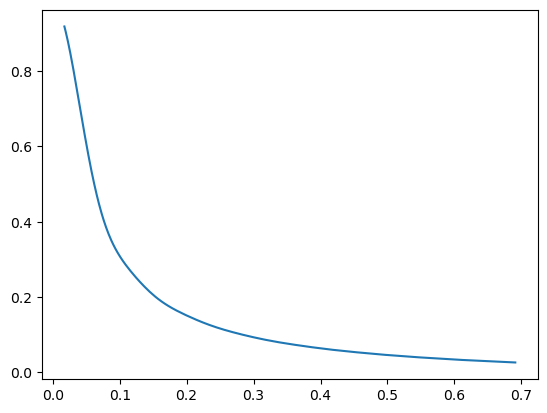

In [34]:
#make q dependent on lambda
lam = np.linspace(0.5, 20, 300) # wavelength in reduced units
n = 1.1 # refractive index
theta = 0.05 #scattering angle
q = 4*np.pi*n/lam * np.sin(theta/2)

p.get_structure_factor(q=q)

plt.figure()
plt.plot(q, p.structure_factor)
plt.show()

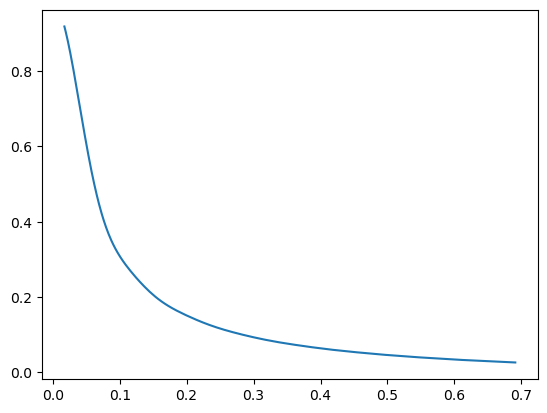

In [40]:
plt.figure()
plt.plot(q, p.structure_factor)
#plt.plot(q,0.1/q)
#plt.loglog()
plt.show()

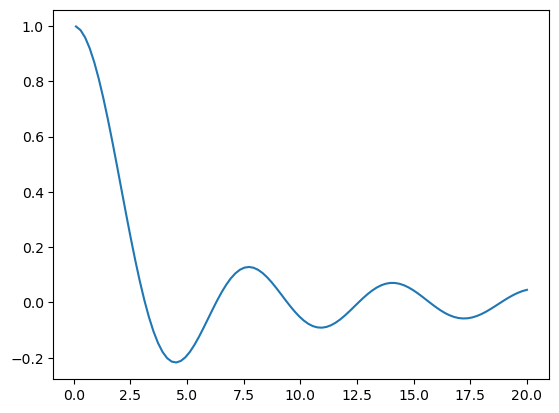

In [33]:
x = np.linspace(0.1, 20, 100)

plt.plot(x, np.sin(x)/x)

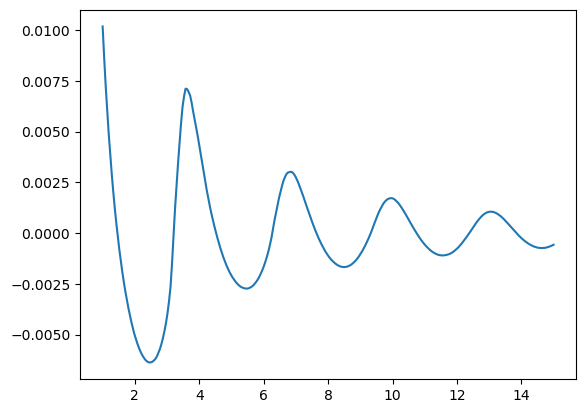

In [26]:
q = np.linspace(1, 15, 300)
p.structure_factor = np.zeros(len(q))
               
for frame in p.trajectory:
    for i in range(p.n_beeds-1):
        for j in range(i+1, p.n_beeds):
            r = frame[j] - frame[i]
            qr = q*np.sqrt(np.dot(r, r))
            p.structure_factor += np.sin(qr)/qr

#factor 2 because of double sum reduction from i,j to i<j
p.structure_factor = p.structure_factor*2/p.n_beeds**2/len(p.trajectory)
plt.figure()
plt.plot(q, p.structure_factor)
plt.show()

In [30]:
mobility = 0.0005
steps = 1000


parameter_list = ((0.25, 2.08, 10))
for k, params in enumerate(parameter_list):
    # p1 = Polymer(n_beeds=n_beeds, mobility=mobility, q_beed=0, epsilon_LJ=0)
    
    eps = params[0]
    q = params[1]
    n_beeds = params[2]
    
    p1 = Polymer(n_beeds=n_beeds, mobility=mobility, epsilon_LJ=eps, q_beed=q)
    p1.create_chain(axis=1)

    t1 = time()
    p1.simulate(steps)
    t2 = time()
    print("simulation time")
    print(f"{(t2-t1)//60:.0f}:{(t2-t1)%60:2.0f} min")
    
    print("Parameters:", params)
    
    p1.save_traj_gro()    
    
    #p1.get_CM_MSD(plot=True)
    p1.get_CM_MSD(plot=True)
    p1.plot_distance_distribution()


TypeError: 'float' object is not subscriptable

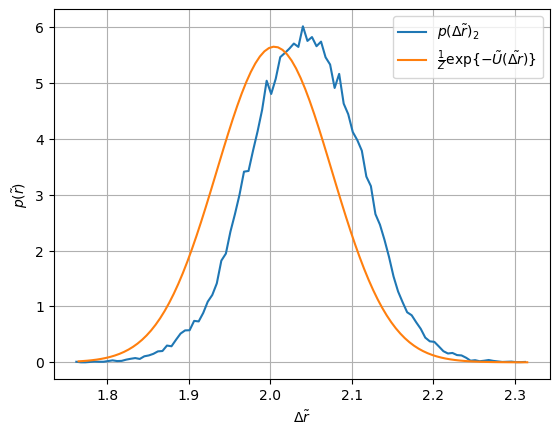

In [27]:
p1.save_traj_gro()
p1.plot_distance_distribution()

In [ ]:
# calculate distribution of distances between two neighbouring beeds
n_beeds = 20
distances_nn = list(())
diff = 0 # number of beeds on the two ends of the chain that shouldnt be included
for frame in trajectory.xyz:
    distances_nn.append(np.sqrt(np.sum((frame[diff:n_beeds-1-diff] - frame[1+diff:n_beeds-diff])**2, axis=1)))

distances_nn = np.array(distances_nn).ravel()

print(np.min(distances_nn))
print(np.max(distances_nn))

n_bins = 200
bin_interval = (np.min(distances_nn), np.max(distances_nn))
#bin_interval = (1.0, 3.5)

histogram_nn, edges_nn = np.histogram(distances_nn, bins=n_bins, range=bin_interval, density=True)

In [ ]:
msd_tid = tid.msd(traj_cm)
msd_tid_x = tid.msd(traj_cm[:,0])
msd_tid_y = tid.msd(traj_cm[:,1])
msd_tid_z = tid.msd(traj_cm[:,2])

t = np.arange(n_frames)

plt.figure()
#plt.loglog(t[1:], msd_fast, label=r"$\langle \Delta\tilde{r}^2\rangle$")
#plt.loglog(t[1:], msd_x, label=r"$\langle \Delta\tilde{r}_x^2\rangle$")
#plt.loglog(t[1:], msd_y, label=r"$\langle \Delta\tilde{r}_y^2\rangle$")
#plt.loglog(t[1:], msd_z, label=r"$\langle \Delta\tilde{r}_z^2\rangle$")
#plt.loglog(t[1:], msd_x+msd_y+msd_z, label="1+2+3")
plt.loglog(t[1:], 2*t[1:]*mobility, label=r"$2t\tilde{\mu}_0$", linestyle="--")
plt.loglog(t[1:], 6*t[1:]*mobility, label=r"$6t\tilde{\mu}_0$", linestyle="--")
#plt.loglog(t[1:], msd_mdt, label="mdtraj")
plt.loglog(t[1:], msd_tid[1:]*n_beeds, label="tidyn")
plt.loglog(t[1:], msd_tid_x[1:]*n_beeds, label="tidyn x")
plt.loglog(t[1:], msd_tid_y[1:]*n_beeds, label="tidyn y")
plt.loglog(t[1:], msd_tid_z[1:]*n_beeds, label="tidyn z")
plt.xlabel(r"$t/\Delta t$")
plt.ylabel("MSD")
plt.legend()
plt.show()

In [ ]:

def analytical_potential(r, polymer):
    K = polymer.force_constant_nn
    r0 = polymer.r0_beeds
    epsilon = polymer.epsilon_LJ 
    sigma = polymer.sigma_LJ
    q = polymer.q_beed
    lB = polymer.lB_debye
    L_s = 1/(38.46153*polymer.c_S)
    
    u_nn = K*(r-r0)**2
    u_LJ = 4*epsilon*(sigma**12/r**12 - sigma**7/r**6 + 1)
    u_Deb = q**2*lB*np.exp(-L_s*r)/r
   
    return u_nn #+ u_LJ + u_Deb

In [16]:
# process trajectory using mdtraj

fname_top = f'polymer_{n_beeds:d}_beeds.pdb'
fname_traj = f"traj_{n_beeds:d}beeds_{steps:d}frames_{mobility:.5f}mu.gro"

# save trajectory in mdtraj to create .gro simulation trajectory
topology = md.load(fname_top).topology
trajectory = md.Trajectory(p1.trajectory, topology)

# save as gromacs file
trajectory.save_gro(filename=fname_traj)

# alternatively load traj from saved files
# trajectory = md.load(fname_traj, top=fname_top)

In [15]:
# alternatively load traj from saved files
n_beeds = 20
steps = 100000
mobility = 0.0005


fname_top = f'topologies/polymer_{n_beeds:d}_beeds.pdb'
fname_traj = f"trajectories/traj_{n_beeds:d}beeds_{steps:d}frames_{mobility:.5f}mu_onlyHarmonic.gro"

trajectory = md.load(fname_traj, top=fname_top)


list

In [79]:
# calculate radius of gyration 

deviation_cm = np.zeros((p1.n_beeds))
for frame, r_cm in zip(p1.trajectory, traj_cm):
    deviation_cm += np.sum((frame-r_cm)**2, axis=1)

Rg = np.sqrt(np.sum(deviation_cm/n_frames)/p1.n_beeds)

print(Rg)
    

6.265390878155055
